In [1]:
import spacy
import scispacy
import deplacy
from spacy import displacy
import stanza
import re
import pandas as pd
from scispacy.abbreviation import AbbreviationDetector
from scispacy.hyponym_detector import HyponymDetector
from spacy.matcher import Matcher
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#loading the data
with open ("/Users/abhinavshinow/Documents/GitHub/KG-Genaration-from-Biomedical-Text-Using-NER/Data_Collection/heart_basic-data.txt","r") as f:
    text=f.read().replace("\n\n"," ").replace("\n"," ")
text=text[:100000]

In [3]:
len(text)

100000

In [4]:
#loading the scispacy core model
nlp_core = spacy.load("en_core_sci_lg")
nlp_core.add_pipe("abbreviation_detector")
nlp_core.add_pipe("hyponym_detector", last=True, config={"extended": False})

#loading the scispacy ner models
nlp_jnlpba = spacy.load('en_ner_jnlpba_md')
nlp_craft = spacy.load('en_ner_craft_md')
nlp_bionlp = spacy.load('en_ner_bionlp13cg_md')
nlp_bc5cdr = spacy.load('en_ner_bc5cdr_md')

#loading the stanza model
nlp_stanza = stanza.Pipeline('en', package='mimic', processors={'ner': 'i2b2'})

2021-12-11 07:53:46 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| pos       | mimic   |
| lemma     | mimic   |
| depparse  | mimic   |
| ner       | i2b2    |

2021-12-11 07:53:46 INFO: Use device: cpu
2021-12-11 07:53:46 INFO: Loading: tokenize
2021-12-11 07:53:46 INFO: Loading: pos
2021-12-11 07:53:46 INFO: Loading: lemma
2021-12-11 07:53:46 INFO: Loading: depparse
2021-12-11 07:53:46 INFO: Loading: ner
2021-12-11 07:53:47 INFO: Done loading processors!


In [5]:
nlp_core.pipe_labels['ner']

['ENTITY']

In [6]:
doc=nlp_core(text)

In [7]:
for ent in doc.ents:
    print(ent)

heart
muscular organ
animals
pumps blood
blood vessels
circulatory system
pumped blood carries oxygen
nutrients
body
metabolic
waste
carbon dioxide
lungs
humans
heart
size
closed fist
lungs
middle compartment
chest
humans
mammals
birds
heart
chambers
upper left
right atria
lower left
right ventricles
right atrium
ventricle
right heart
left counterparts
left heart
Fish
chambers
atrium
ventricle
reptiles
chambers
healthy
heart blood
heart
heart valves
prevent
backflow
heart
enclosed
protective sac
pericardium
amount
fluid
heart
layers
epicardium
myocardium
endocardium
heart pumps
blood
rhythm
group
pacemaker cells
sinoatrial node
contraction
heart
traveling
atrioventricular node
conduction system
heart
heart
blood low
oxygen
systemic
circulation
right atrium
superior
inferior venae cavae
right ventricle
pumped
pulmonary circulation
lungs
oxygen
carbon dioxide
Oxygenated blood
left atrium
left ventricle
aorta
systemic
circulation−where the oxygen
metabolized
carbon dioxide
heart beats
res

In [8]:
#Hearst Patterns
doc._.hearst_patterns

[('such_as', waste, carbon dioxide),
 ('include', They, MYH6),
 ('include', They, ACTC1),
 ('include', They, TNNI3),
 ('include', They, CDH2),
 ('include', They, PKP2),
 ('such_as', agents, adrenaline),
 ('such_as', agents, noradrenaline),
 ('such_as', agents, dopamine),
 ('include', receptors, baroreceptors),
 ('other', locations, cavae),
 ('other', locations, stretch receptors),
 ('other', locations, side),
 ('include', electrolytes, calcium),
 ('include', electrolytes, potassium),
 ('include', electrolytes, sodium),
 ('other', factors, lifestyle),
 ('include', heart, doctors),
 ('include', heart, surgeons),
 ('include', heart, intensivists),
 ('include', heart, health practitioners),
 ('include', health practitioners, physiotherapists),
 ('include', health practitioners, dieticians),
 ('such_as', toxins, alcohol),
 ('include', investigations, blood tests),
 ('include', investigations, echocardiograms),
 ('include', investigations, ECGs),
 ('include', investigations, imaging),
 ('inc

In [9]:
#Abbreviations
for abrv in doc._.abbreviations:
	print(str(abrv),str(abrv._.long_form))

CVD Cardiovascular diseases
bpm beats per minute
bpm beats per minute
bpm beats per minute
bpm beats per minute
bpm beats per minute
bpm beats per minute
bpm beats per minute
bpm beats per minute
bpm beats per minute
week week after the LMP
week week after the LMP
week week after the LMP
week week after the LMP
week week after the LMP
week week after the LMP
week week after the LMP
CO Cardiac output
CO Cardiac output
SV stroke volume
SV stroke volume
HR heart rate
HR heart rate
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node nodal re-entrant tachycardia
node no

In [10]:
abbreviations=[]
long_form=[]
for abrv in doc._.abbreviations:
    if str(abrv) not in abbreviations:
        if str(abrv)!=str(abrv._.long_form):
            abbreviations.append(str(abrv))
            long_form.append(str(abrv._.long_form))

hyponyms=list(doc._.hearst_patterns)
sources=[str(source[1]) for source in hyponyms]
targets=[str(target[2]) for target in hyponyms]
relations=[str(relation[0]) for relation in hyponyms]

for abrv,abrv_long in zip(abbreviations,long_form):
    sources.append(abrv)
    targets.append(abrv_long)
    relations.append('abbreviated-as')

In [11]:
#Pos Tagging and Dependency parsing
def extract(sent):

  doc=nlp_core(sent)
  matcher = Matcher(nlp_core.vocab)
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("relation",[pattern]) 
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 

  ent1,ent2,prv_tok_dep,prv_tok_text,prefix,modifier = "","","","","",""
  for tok in nlp_core(sent):
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""   

      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
  return [ent1.strip(),span.text,ent2.strip()]

In [12]:
ner_core=[]
for sent in doc.sents:
    source=extract(str(sent))[0]
    relation=extract(str(sent))[1]
    target=extract(str(sent))[2]
    if not any(re.search("^\s*$",s) for s in [source,target,relation]):
        ner_core.append(extract(str(sent)))
        sources.append(source)
        relations.append(relation)
        targets.append(target)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scispacy/abbreviation.py:216: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


In [13]:
for enitity_relations in ner_core:
    print(enitity_relations)

['animals  which', 'organ', 'blood']
['pumped  blood', 'carries', 'metabolic  waste']
['two  reptiles', 'have', 'three  chambers']
['heart valves heart which', 'flows', 'backflow']
['sac  which', 'enclosed', 'small  amount']
['heart', 'pumps', 'blood']
['that', 'generate', 'contraction']
['circulation  which', 'receives', 'right  atrium']
['where  it', 'pumped', 'carbon dioxide']
['Exercise', 'increases', 'resting heart rate']
['Cardiovascular  diseases', 'have', 'chest  pain']
['Structure Location', 'situated', 'human  heart']
['double-membraned  sac', 'surrounds', 'heart']
['left  lung', 'smaller', 'border  heart']
['adult  heart', 'has', 'mass']
['Well-trained  athletes', 'have', 'larger  hearts']
['Chambers', 'has', 'four  chambers']
['tissue  this', 'made', 'structure']
['fibrous  which', 'forms', 'atria']
['conduction system conduction collagen', 'provides', 'electricity']
['interventricular  septum', 'separates', 'ventricles']
['when  they', 'thicker', 'greater  pressure']
['fou

In [14]:
df1=pd.DataFrame({'source-node':sources,'target-node':targets,'relation':relations})


In [15]:
df1['relation'].value_counts()[:50]

include           62
such_as           29
abbreviated-as    22
has               13
have              12
other             10
used               9
treated            6
receives           6
cause              5
involves           4
increase           4
close              4
form               4
allow              4
required           4
found              3
play               3
flows              3
pumps              3
taken              3
experience         3
considered         3
decrease           3
influenced         3
increases          3
require            3
performed          3
causes             3
act                2
located            2
derives            2
smaller            2
occurs             2
period             2
open               2
produces           2
defined            2
travels            2
means              2
affect             2
supplies           2
nerve              2
allows             2
thicker            2
present            2
terminated         2
made         

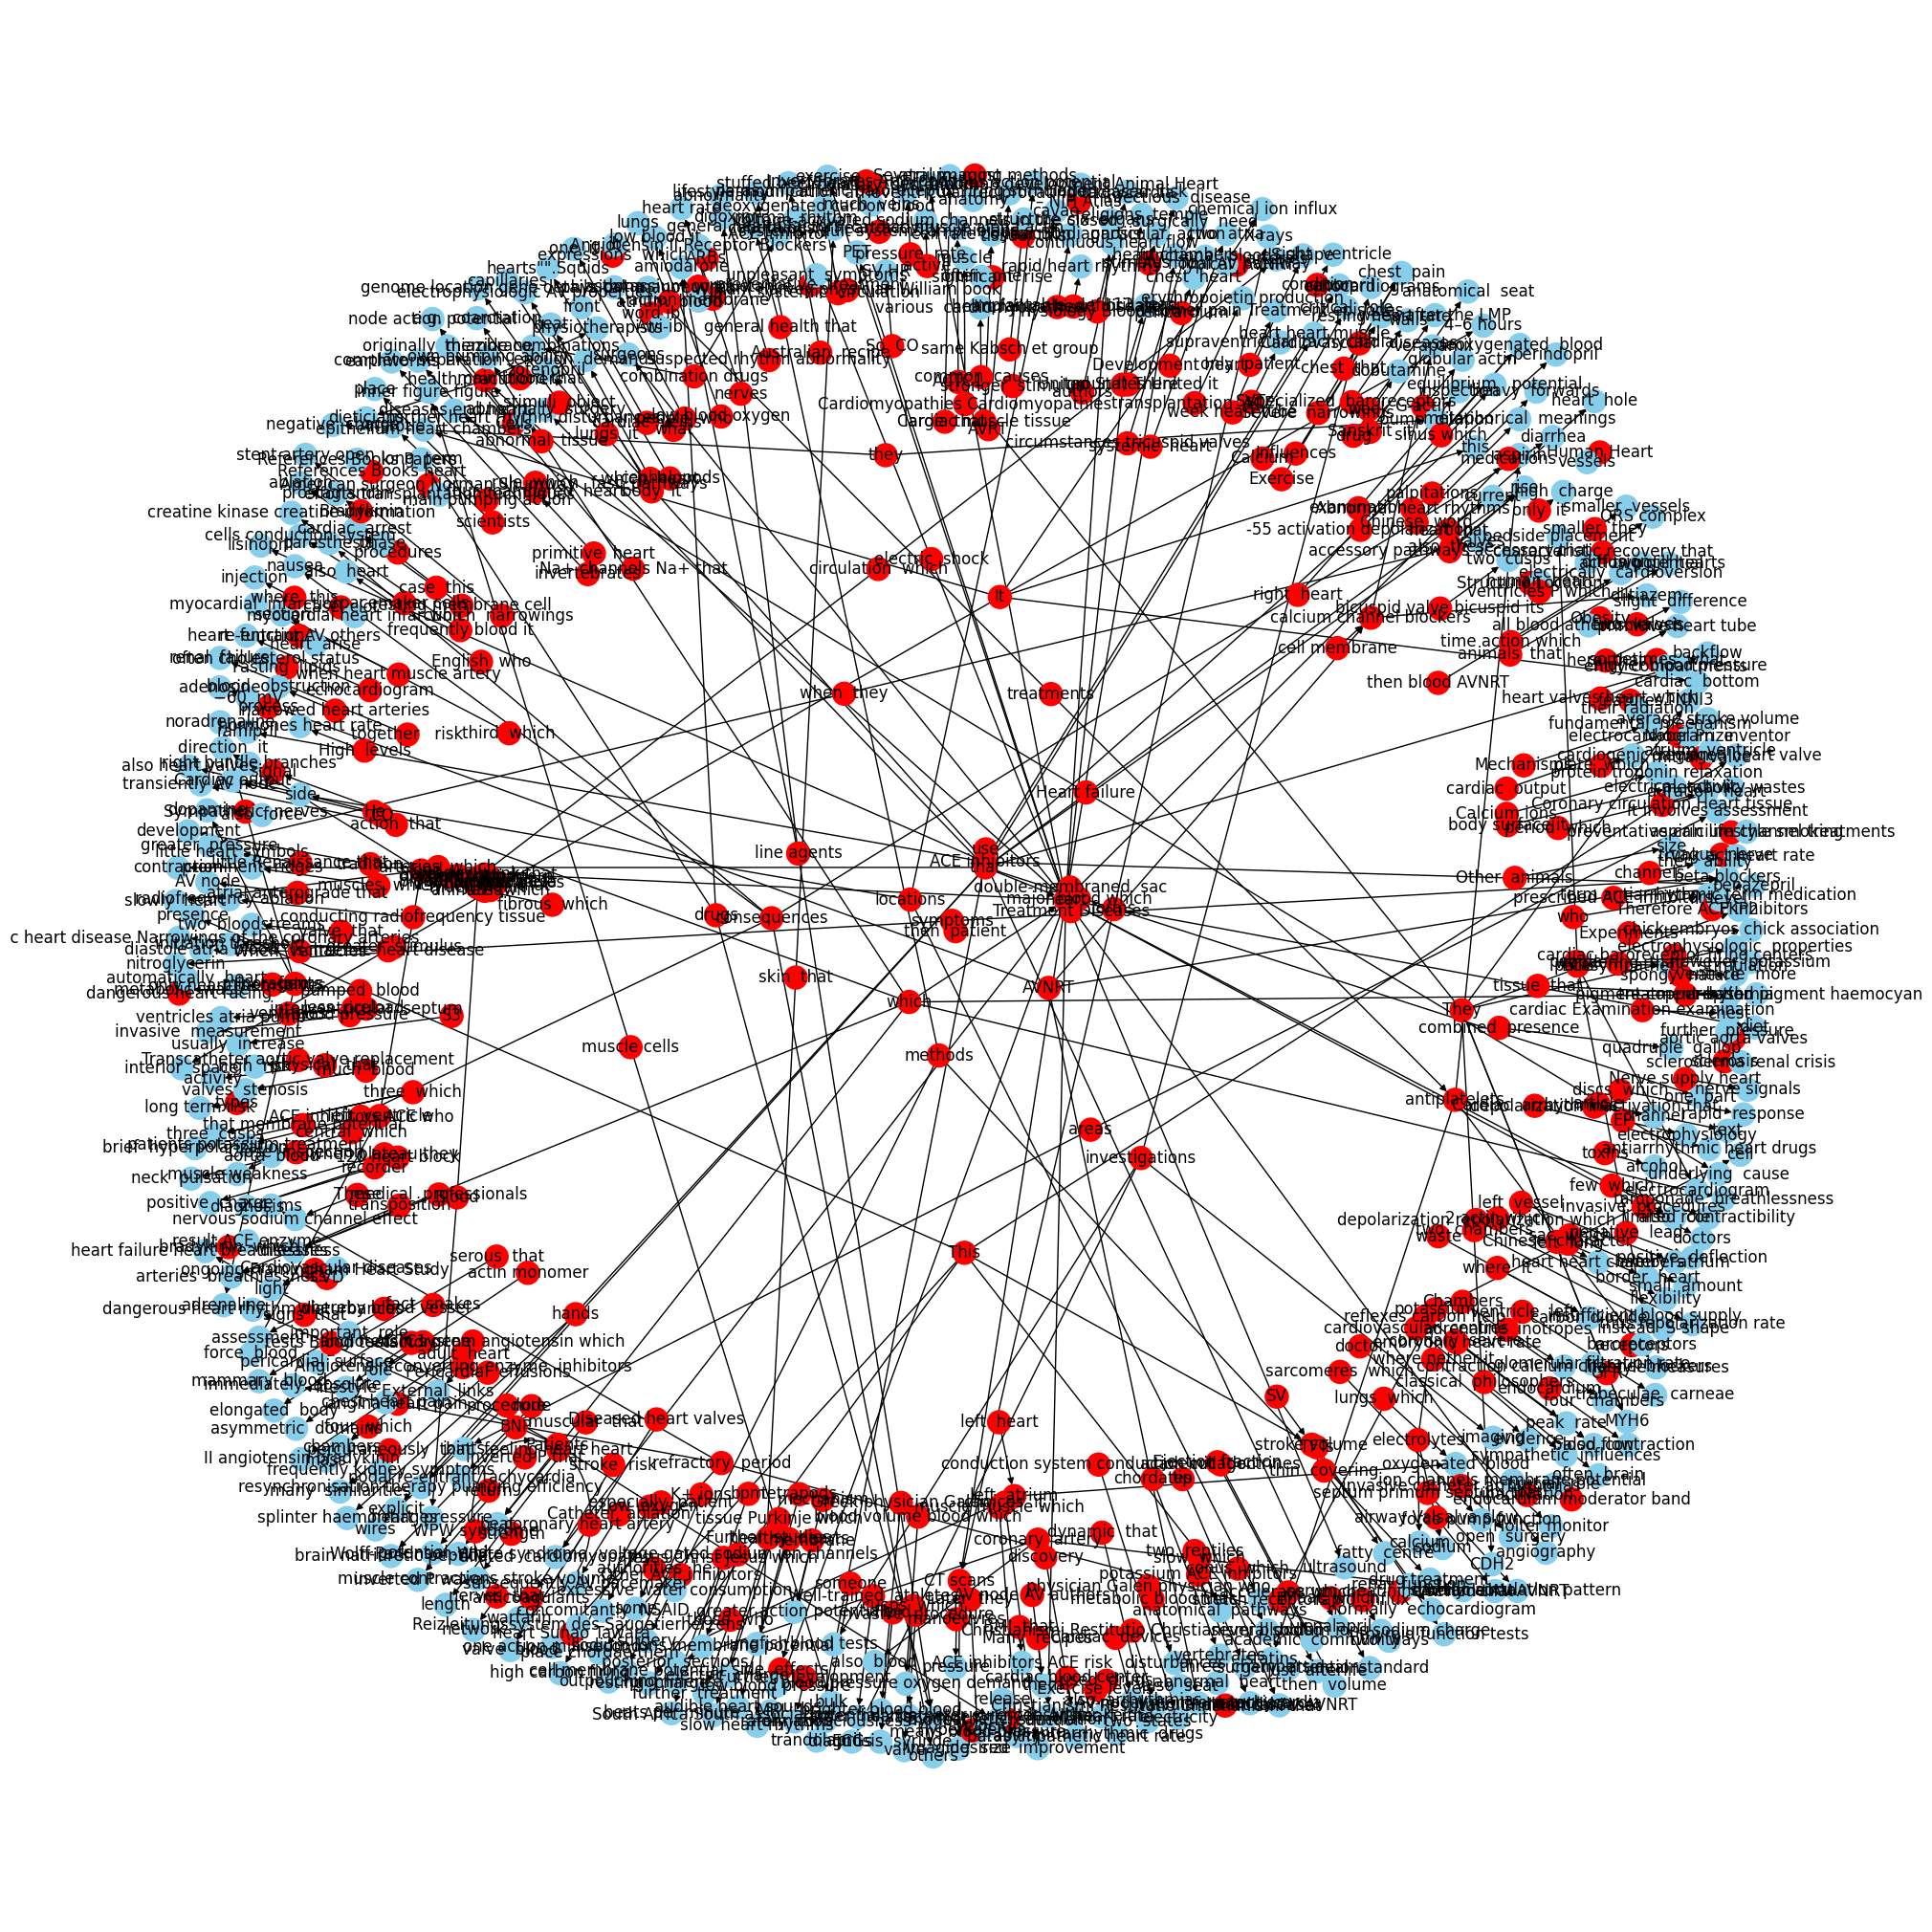

In [16]:
Knowledge_graph1=nx.from_pandas_edgelist(df1, 'source-node', 'target-node', edge_attr=True, create_using=nx.MultiDiGraph())
for n in Knowledge_graph1.nodes():
    Knowledge_graph1.nodes[n]['color'] = 'red' if n in sources else 'skyblue'

plt.figure(figsize=(20,20))
colors = [node[1]['color'] for node in Knowledge_graph1.nodes(data=True)]
pos = nx.spring_layout(Knowledge_graph1)
nx.draw(Knowledge_graph1, with_labels=True, node_color=colors, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [33]:
sources = []
targets = []
relations = []

In [16]:
# for enitity_relations in ner:
#     print(enitity_relations)


#Add method to remove special characters

In [22]:
#Ner Models
print("jnlpba-labels",nlp_jnlpba.pipe_labels['ner'])
print("craft-labels",nlp_craft.pipe_labels['ner'])
print("bionlp-labels",nlp_bionlp.pipe_labels['ner'])
print("Bc5cdr-labels",nlp_bc5cdr.pipe_labels['ner'])

jnlpba-labels ['CELL_LINE', 'CELL_TYPE', 'DNA', 'PROTEIN', 'RNA']
craft-labels ['CHEBI', 'CL', 'GGP', 'GO', 'SO', 'TAXON']
bionlp-labels ['AMINO_ACID', 'ANATOMICAL_SYSTEM', 'CANCER', 'CELL', 'CELLULAR_COMPONENT', 'DEVELOPING_ANATOMICAL_STRUCTURE', 'GENE_OR_GENE_PRODUCT', 'IMMATERIAL_ANATOMICAL_ENTITY', 'MULTI_TISSUE_STRUCTURE', 'ORGAN', 'ORGANISM', 'ORGANISM_SUBDIVISION', 'ORGANISM_SUBSTANCE', 'PATHOLOGICAL_FORMATION', 'SIMPLE_CHEMICAL', 'TISSUE']
Bc5cdr-labels ['CHEMICAL', 'DISEASE']


In [23]:
print("Bc5cdr-labels",nlp_bc5cdr.pipe_labels['ner'])

Bc5cdr-labels ['CHEMICAL', 'DISEASE']


In [24]:
#Entity-Ruler
ruler = nlp_bc5cdr.add_pipe("entity_ruler",after="ner")

In [25]:
#Custom Entities and Labels
pattern = [
    #CVD
    {"label":"CVD","pattern":"cardiomyopathies"},
    {"label":"CVD","pattern":"angina"},
    {"label":"CVD","pattern":"arrhythmia"},
    {"label":"CVD","pattern":"dilated cardiomyopathy"},
    {"label":"CVD","pattern":"hypertrophic cardiomyopathy"},
    {"label":"CVD","pattern":"mitral regurgitation"},
    {"label":"CVD","pattern":"mitral valve prolapse"},
    {"label":"CVD","pattern":"pulmonary stenosis"},
    {"label":"CVD","pattern":"aortic stenosis"},
    {"label":"CVD","pattern":"atrial fibrillation"},
    {"label":"CVD","pattern":"peripheral artery disease"},
    {"label":"CVD","pattern":"aneurysm"},
    {"label":"CVD","pattern":"atherosclerosis"},
    {"label":"CVD","pattern":"raynaud’s disease"},
    {"label":"CVD","pattern":"peripheral venous disease"},
    {"label":"CVD","pattern":"ischemic stroke"},
    {"label":"CVD","pattern":"venous blood clots"},
    {"label":"CVD","pattern":"buerger’s disease"},
    
    #Drug
    {"label":"Drug","pattern":"statins"},
    {"label":"Drug","pattern":"aspirin"},
    {"label":"Drug","pattern":"clopidogrel"},
    {"label":"Drug","pattern":"warfarin"},
    {"label":"Drug","pattern":"beta-blockers"},
    {"label":"Drug","pattern":"ace inhibitors"},
    {"label":"Drug","pattern":"apixaban"},
    {"label":"Drug","pattern":"dabigatran"},
    {"label":"Drug","pattern":"edoxaban"},
    {"label":"Drug","pattern":"heparin"},
    {"label":"Drug","pattern":"rivaroxaban"},
    {"label":"Drug","pattern":"dipyridamole"},
    {"label":"Drug","pattern":"prasugrel"},
    {"label":"Drug","pattern":"ticagrelor"},
    
    #Symptoms
    {"label":"Symptoms","pattern":"chest pain"},
    {"label":"Symptoms","pattern":"chest tightness"},
    {"label":"Symptoms","pattern":"chest pressure"},
    {"label":"Symptoms","pattern":"chest discomfort"},
    {"label":"Symptoms","pattern":"shortness of breath"},
    {"label":"Symptoms","pattern":"numbness"},
    {"label":"Symptoms","pattern":"coldness"},
    {"label":"Symptoms","pattern":"neck pain"},
    {"label":"Symptoms","pattern":"jaw pain"},
    {"label":"Symptoms","pattern":"throat pain"},
    {"label":"Symptoms","pattern":"upper abdomen pain"},
    {"label":"Symptoms","pattern":"back pain"},
    
    #Parts of the human heart
    {"label":"Parts of the human heart","pattern":"superior vena cava"},
    {"label":"Parts of the human heart","pattern":"inferior vena cava"},
    {"label":"Parts of the human heart","pattern":"pulmonary vein"},
    {"label":"Parts of the human heart","pattern":"right atrium"},
    {"label":"Parts of the human heart","pattern":"pulmonary valve"},
    {"label":"Parts of the human heart","pattern":"tricuspid valve"},
    {"label":"Parts of the human heart","pattern":"right ventricle"},
    {"label":"Parts of the human heart","pattern":"aorta"},
    {"label":"Parts of the human heart","pattern":"pulmonary artery"},
    {"label":"Parts of the human heart","pattern":"left atrium"},
    {"label":"Parts of the human heart","pattern":"mitral valve"},
    {"label":"Parts of the human heart","pattern":"aortic valve"},
    {"label":"Parts of the human heart","pattern":"left ventricle"},
    
    #Causes
    {"label":"Causes","pattern":"family history"},
    {"label":"Causes","pattern":"smoking"},
    {"label":"Causes","pattern":"poor diet"},
    {"label":"Causes","pattern":"high blood pressure"},
    {"label":"Causes","pattern":"high blood cholesterol levels"},
    {"label":"Causes","pattern":"age"},
    {"label":"Causes","pattern":"sex"},
    {"label":"Causes","pattern":"stress"},
    {"label":"Causes","pattern":"obesity"},
    {"label":"Causes","pattern":"physical inactivity"},
    {"label":"Causes","pattern":"stress"},
    {"label":"Causes","pattern":"poor dental health"},
    
    #Complications
    {"label":"Complications","pattern":"heart failure"},
    {"label":"Complications","pattern":"heart attack"},
    {"label":"Complications","pattern":"stroke"},
    {"label":"Complications","pattern":"aneurysm"},
    {"label":"Complications","pattern":"peripheral artery disease"},
    {"label":"Complications","pattern":"sudden cardiac arrest"},

    #Prevention
    {"label":"Prevention","pattern":"healthy weight"},
    {"label":"Prevention","pattern":"manage stress"},
    {"label":"Prevention","pattern":"hygiene"},
    {"label":"Prevention","pattern":"exercise"},
    {"label":"Prevention","pattern":"diet"},
    ]

In [26]:
for i in range(len(pattern)):
    s = pattern[i]['pattern']
    s_cap = s.upper()
    s_fcap = s.capitalize()
    pattern.append({"label":pattern[i]['label'],"pattern":s_cap})
    pattern.append({"label":pattern[i]['label'],"pattern":s_fcap})

In [27]:
ruler.add_patterns(pattern)

doc_ner1 = nlp_bc5cdr(text)
doc_ner2 = nlp_jnlpba(text)
doc_ner3 = nlp_craft(text)
doc_ner4 = nlp_bionlp(text)

In [28]:
for ents in doc_ner1.ents:
    print(ents)

oxygen
carbon dioxide
right atrium
oxygen
right atrium
inferior venae cavae
right ventricle
oxygen
carbon dioxide
left atrium
left ventricle
aorta
circulation−where
oxygen
carbon dioxide
heart beats
Exercise
Cardiovascular diseases
death
deaths
coronary artery disease
stroke
smoking
exercise
cholesterol
high blood pressure
diabetes
Cardiovascular diseases
chest pain
shortness of breath
heart disease
diseases of the heart
aorta
pulmonary trunk
cardiac notch
exercise
heart muscle
right atrium
left atrium
right atrium
right ventricle
left atrium
left ventricle
right atrium
right ventricle
tricuspid valve
tricuspid valve
mitral valve
left atrium
left ventricle
pulmonary valve
pulmonary artery
aortic valve
aorta
aorta
right atrium
right ventricle
tricuspid valve
right atrium
veins
right atrium
inferior vena cava
right atrium
depression
right atrium
depression
right atrium
right ventricle
tricuspid valve
right ventricle
cardiac muscle
cardiac muscle
right ventricle
right ventricle
inferior p

In [29]:
html=displacy.render(doc_ner1,style="ent")

In [26]:
html=displacy.render(doc_ner2,style="ent")

In [27]:
html=displacy.render(doc_ner3,style="ent")

In [28]:
html=displacy.render(doc_ner4,style="ent")

In [35]:
#Label's and Entities added to source , target and relations list

docs=[doc_ner1,doc_ner2,doc_ner3,doc_ner4]
for doc in docs:
    for ents in doc.ents:
        sources.append(ents.text)
        targets.append(ents.label_)
        relations.append('NER')

In [36]:
df2=pd.DataFrame({'source-node':sources,'target-node':targets,'relation':relations})

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


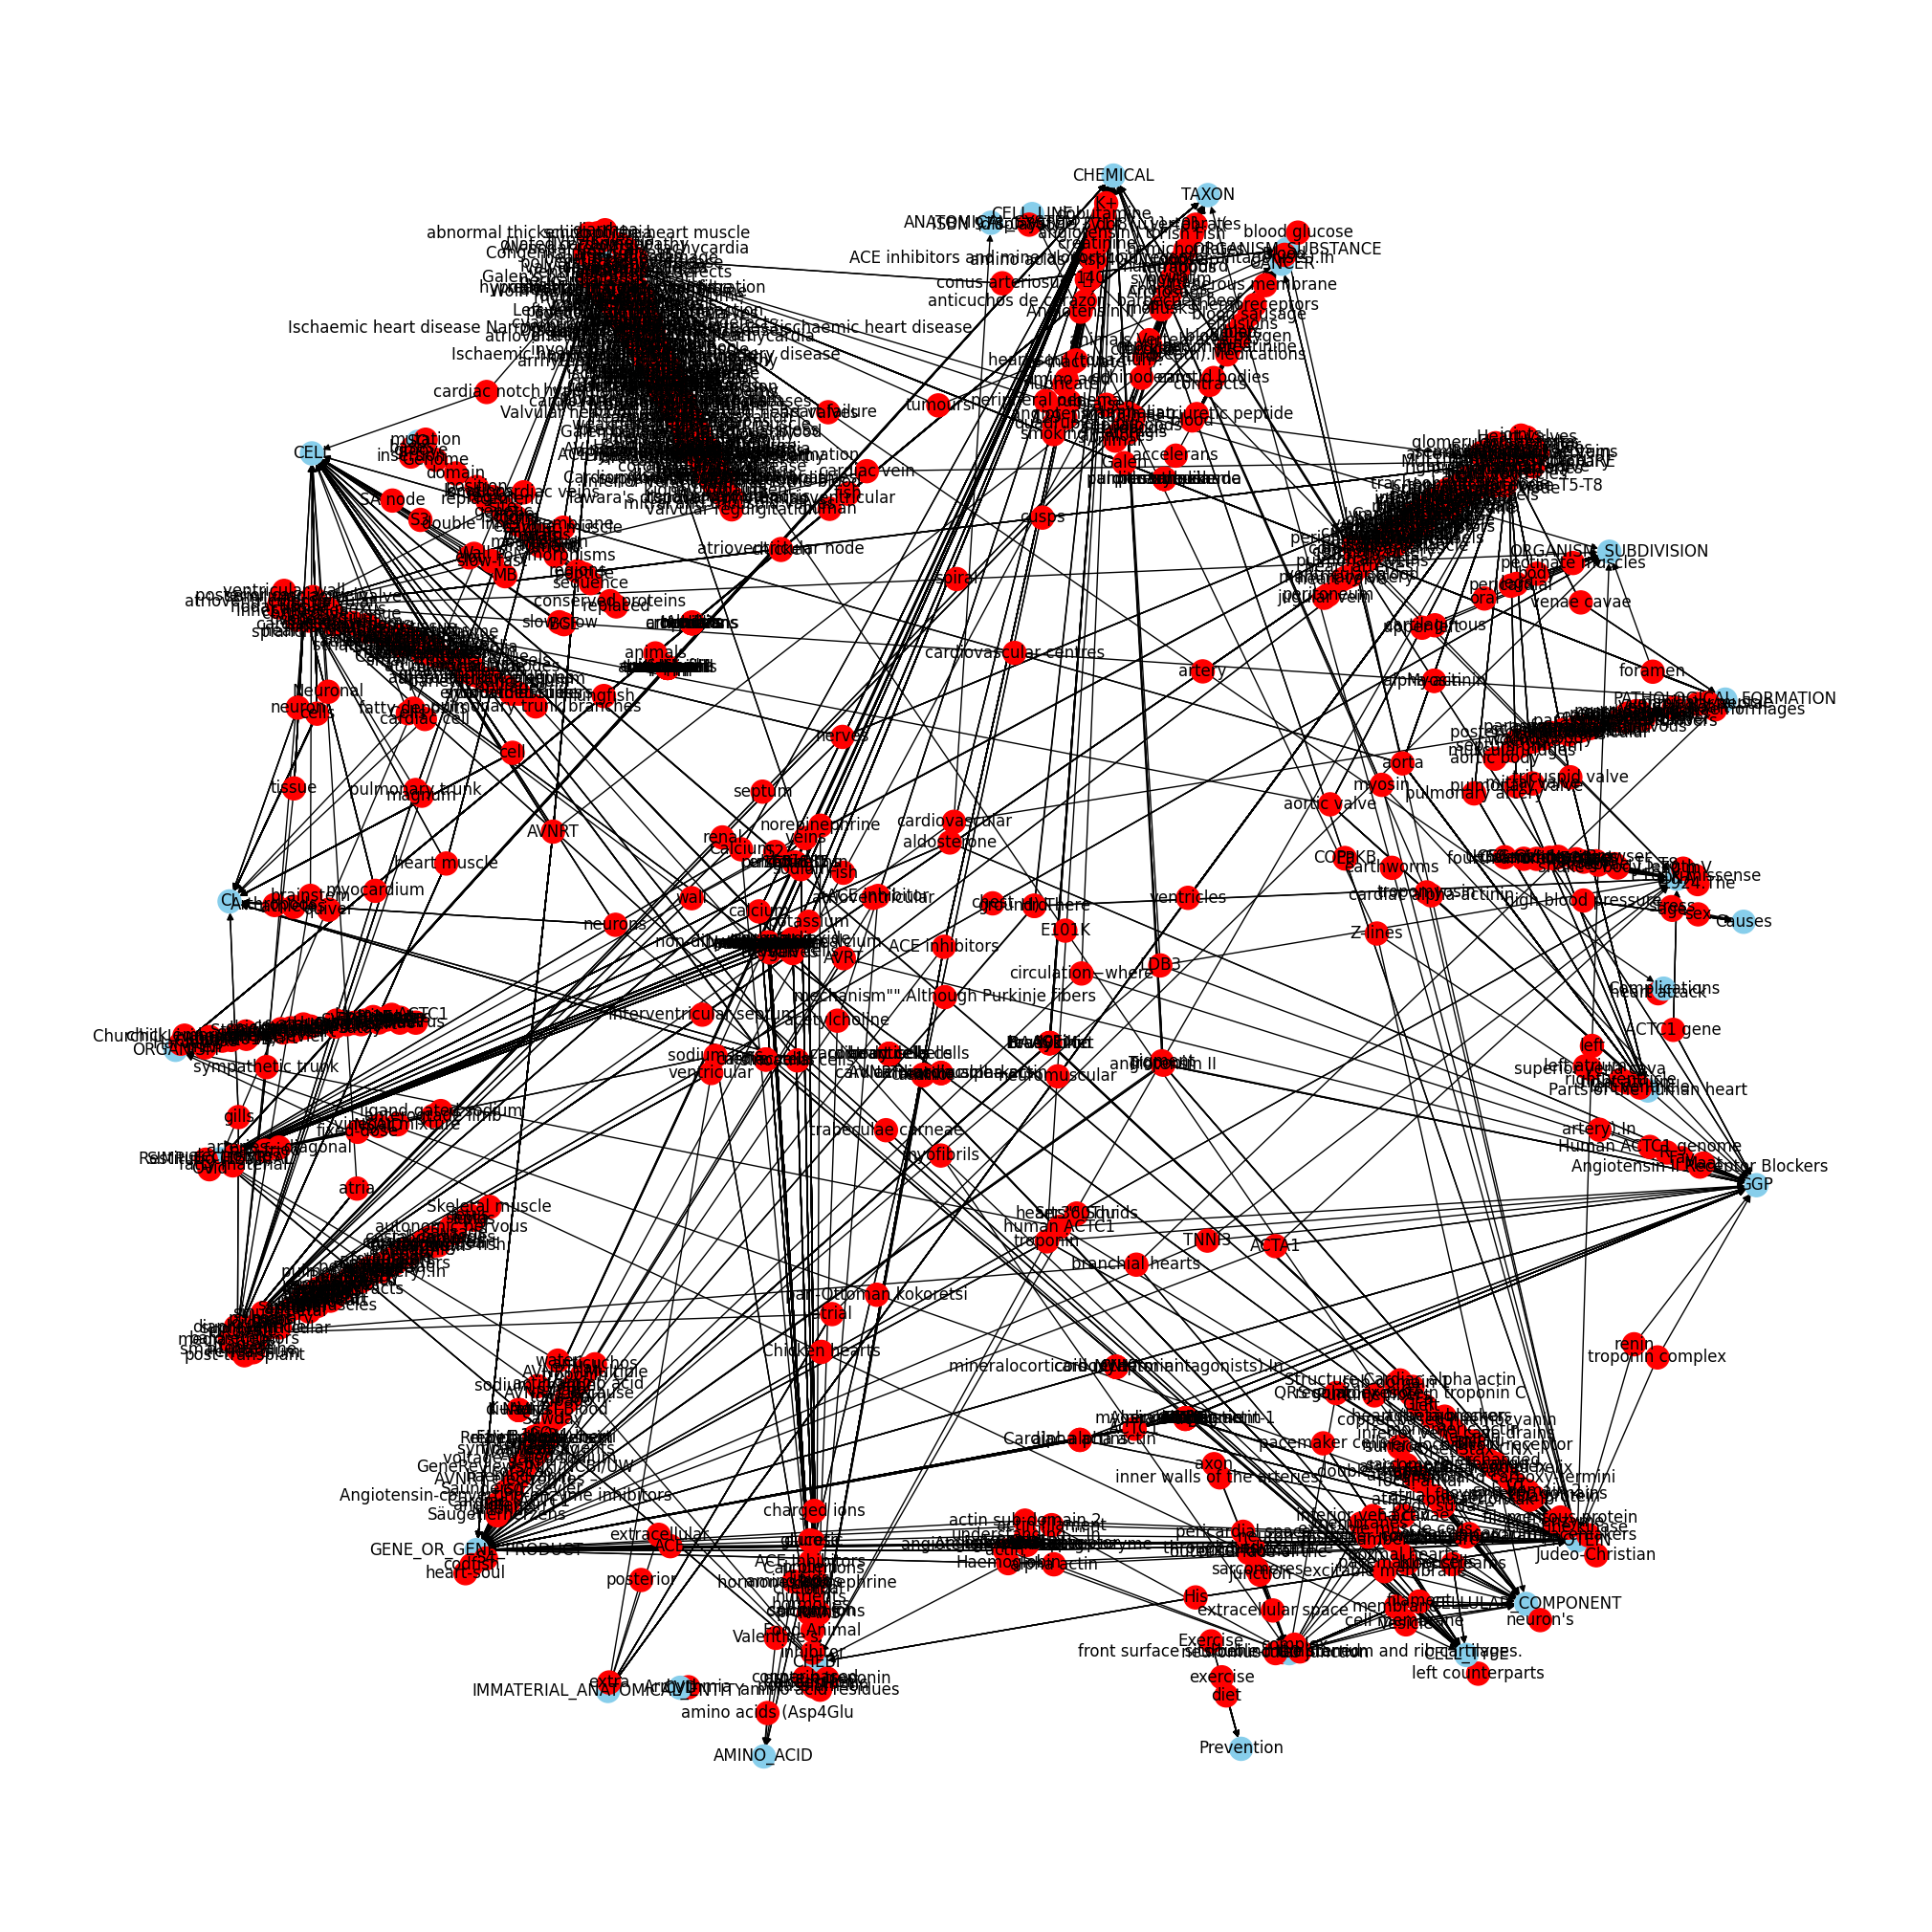

In [37]:
Knowledge_graph2=nx.from_pandas_edgelist(df2, 'source-node', 'target-node', edge_attr=True, create_using=nx.MultiDiGraph())
for n in Knowledge_graph2.nodes():
    Knowledge_graph2.nodes[n]['color'] = 'red' if n in sources else 'skyblue'

plt.figure(figsize=(20,20))
colors = [node[1]['color'] for node in Knowledge_graph2.nodes(data=True)]
pos = nx.spring_layout(Knowledge_graph2)
nx.draw(Knowledge_graph2, with_labels=True, node_color=colors, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [38]:
doc_stanza = nlp_stanza(text)

In [31]:
#print both here

In [40]:
texts =[[]]
ners =[[]]
i=0
for sent in doc_stanza.ents:
    text=[]
    ner=[]
    for token in sent.tokens:
        text.append(token.text)
        ner.append(token.ner)
    texts.append(text)
    ners.append(ner)

In [41]:
pattern = [['B-PROBLEM', 'I-PROBLEM', 'E-PROBLEM'],['B-TREATMENT', 'I-TREATMENT', 'E-TREATMENT'],['B-TEST', 'I-TEST', 'E-TEST']]
sources1 =[]
relations1 = []
targets1 =[]
for val in ners:
    if val in pattern:
        if texts[ners.index(val)][0] not in sources1:
            sources1.append(texts[ners.index(val)][0])
            relations1.append(texts[ners.index(val)][1])
            targets1.append(texts[ners.index(val)][2]) 

In [42]:
for i in range(len(sources1)):
    sources.append(sources1[i])
    targets.append(targets1[i])
    relations.append(relations1[i])

In [44]:
df3=pd.DataFrame({'source-node':sources,'target-node':targets,'relation':relations})

In [45]:
df3['relation'].value_counts()[:50]

NER                 3416
heart                  1
resting                1
atrioventricular       1
Name: relation, dtype: int64

In [46]:
df3.head()

source-node               target-node relation
0          oxygen                  CHEMICAL      NER
1  carbon dioxide                  CHEMICAL      NER
2    right atrium  Parts of the human heart      NER
3          oxygen                  CHEMICAL      NER
4    right atrium  Parts of the human heart      NER

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


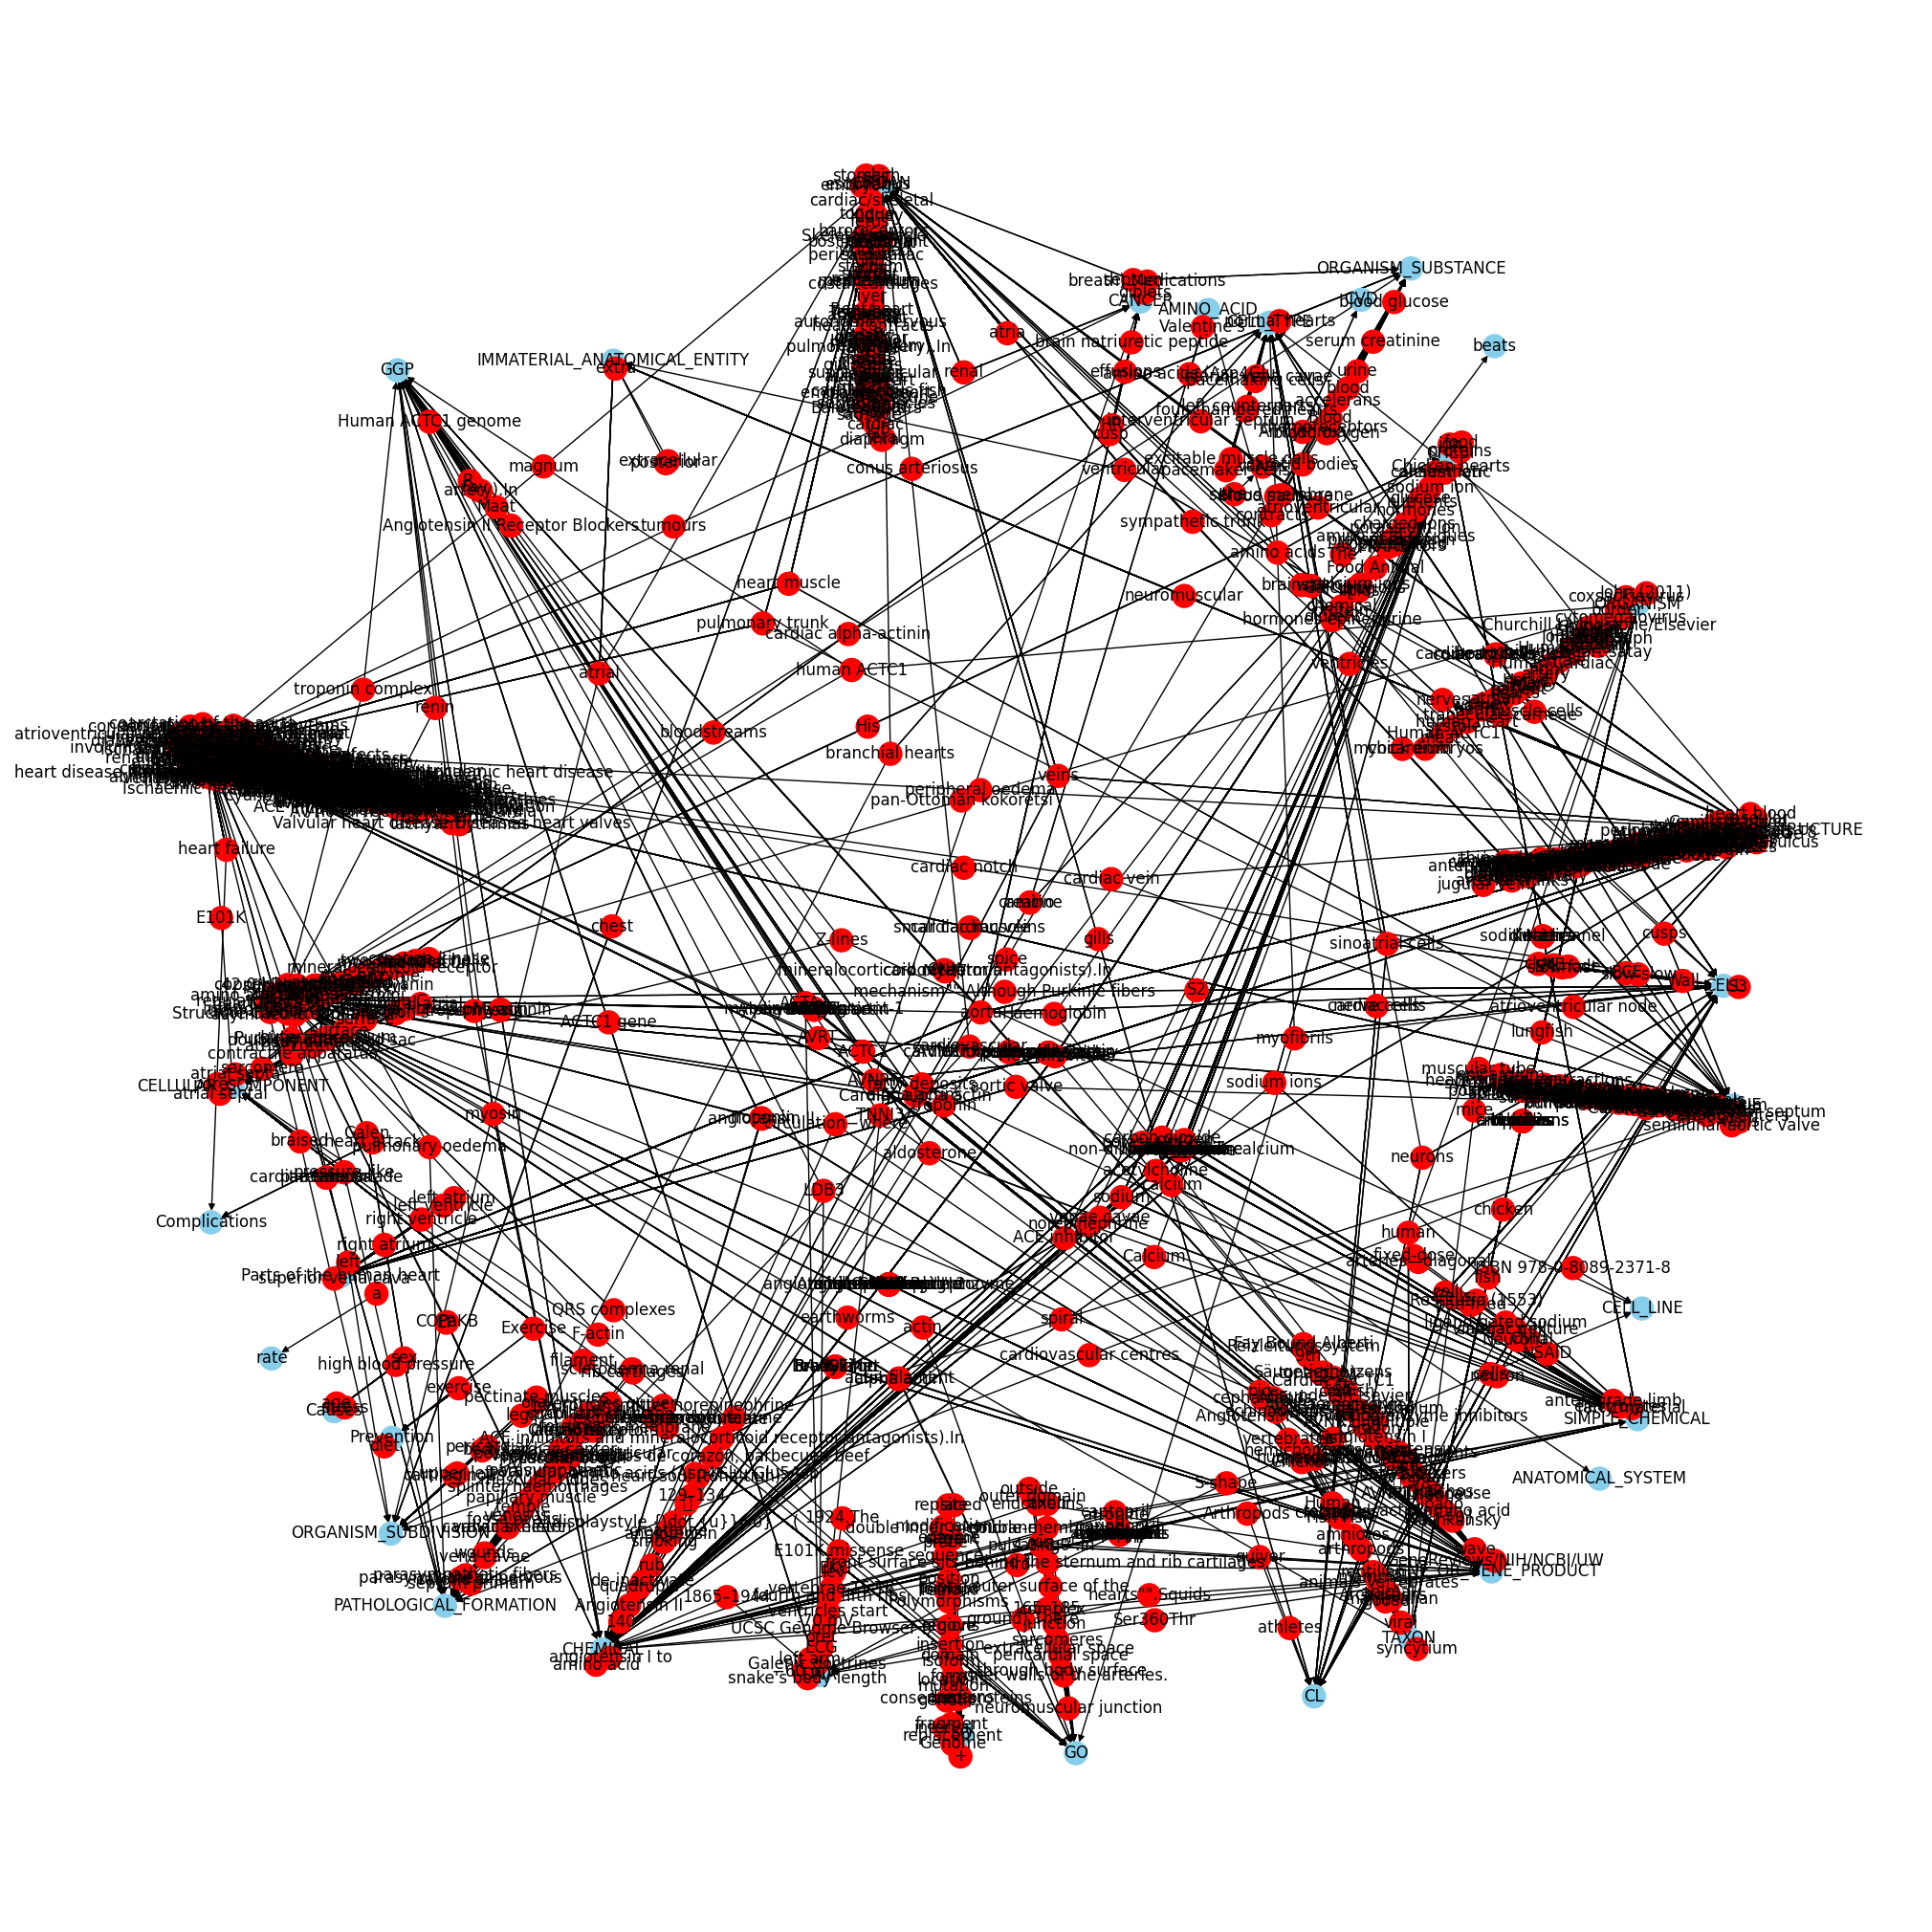

In [47]:
Knowledge_graph=nx.from_pandas_edgelist(df3, 'source-node', 'target-node', edge_attr=True, create_using=nx.MultiDiGraph())
for n in Knowledge_graph.nodes():
    Knowledge_graph.nodes[n]['color'] = 'red' if n in sources else 'skyblue'

plt.figure(figsize=(20,20))
colors = [node[1]['color'] for node in Knowledge_graph.nodes(data=True)]
pos = nx.spring_layout(Knowledge_graph)
nx.draw(Knowledge_graph, with_labels=True, node_color=colors, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()